# DL - Adversarial network

In [77]:
import tensorflow as tf
import Layers
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load the image

We load the image and adapt it (color and size) to the model:

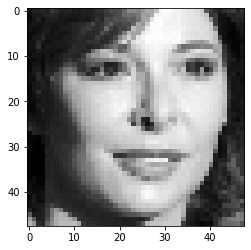

In [106]:
# Load  the image and adapt it to the model
im = cv2.imread("./images/input.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = cv2.resize(im, (48, 48))
im = (im - 128.0) / 256.0
plt.imshow(im, cmap='gray')
plt.show()

## Load the CNN model

The model we use is a Convolutional Neural Network, trained to find the gender of a person on an image. It has been trained previously and its checkpoints had been saved. The checkpoints contains the value of all parameters (tf.Variable) used by a model (see the [documentation](https://www.tensorflow.org/guide/checkpoint)). It is useful when we have the structure of the network.<br />
The model has an accuracy of 88.64% on a test set. It will we be enough for our use case.

In [79]:
class ConvNeuralNet(tf.Module):
    def __init__(self):
        self.unflat = Layers.unflat(48, 48, 1)
        self.cv1 = Layers.conv(output_dim=3, filterSize=5, stride=1)
        self.mp = Layers.maxpool(2)
        self.cv2 = Layers.conv(output_dim=6, filterSize=5, stride=1)
        self.cv3 = Layers.conv(output_dim=12, filterSize=5, stride=1)
        self.flat = Layers.flat()
        self.fc = Layers.fc(2)

    def __call__(self, x):
        x = self.unflat(x)
        x = self.cv1(x)
        x = self.mp(x)
        x = self.cv2(x)
        x = self.mp(x)
        x = self.cv3(x)
        x = self.mp(x)
        x = self.flat(x)
        x = self.fc(x)
        return x

optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.1)
simple_cnn = ConvNeuralNet()

# Load the saved checkpoint (containing the values of the paramaters of the trained model)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn)
ckpt.restore('./saved_model-3-1')

## Create and train a noise filter

We create a new variable, DX, which will be the noise filter. It has the shape of an image, (48,48), and is initialized with null values.

In [80]:
# Create the constant X, representing the image
X = tf.constant(im, dtype=np.float32)

# Create the variable DX, the filter
DXinit = tf.constant(0.0, shape=[48, 48])
DX = tf.Variable(DXinit)

We train the model over 1000 iterations. We only train the new variable, DX, in order to find the more adapted filter.<br />
To only train the DX variable, we indicate DX in the calculation of the gradient: grads = tape.gradient(loss, [DX])<br />
We previously set up the optimizer with the class GradientDescentOptimizer, in order to optimize the gradient descent.<br />

The loss is calculated, at each iteration, on the image computed with the filter (X + DX).<br />

In [88]:
def train_filter(model, optimizer, X, label, DX):
    with tf.GradientTape() as tape:
        y = model(X + DX)
        y = tf.nn.log_softmax(y)
        diff = label * y
        loss = -tf.reduce_sum(diff)
        grads = tape.gradient(loss, [DX])
        optimizer.apply_gradients(zip(grads, [DX]))
    return loss

fake_label = [1.0, 0.0]
for iter in range(1000):
    loss = train_filter(simple_cnn, optimizer, X, fake_label, DX)

    if iter % 100 == 0:
        print("iter= %6d - loss= %f" % (iter, loss))
print("iter= %6d - loss= %f" % (999, loss))

iter=      0 - loss= 0.031232
iter=    100 - loss= 0.001360
iter=    200 - loss= 0.000730
iter=    300 - loss= 0.000517
iter=    400 - loss= 0.000403
iter=    500 - loss= 0.000330
iter=    600 - loss= 0.000278
iter=    700 - loss= 0.000240
iter=    800 - loss= 0.000212
iter=    900 - loss= 0.000190
iter=    999 - loss= 0.000173


## Display the resulting image

We display the generated filter, DX:

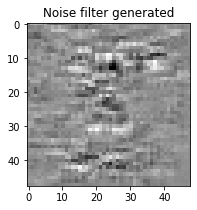

In [82]:
DX_render = DX.numpy()
plt.figure(figsize=(3,3))
plt.imshow(DX_render, cmap='gray')
plt.title("Noise filter generated")
plt.show()

We observe that the most impacted points of the image are at the eyes, the nose and the chin.<br />
We display the resulting image, composed of the original image + the filter.

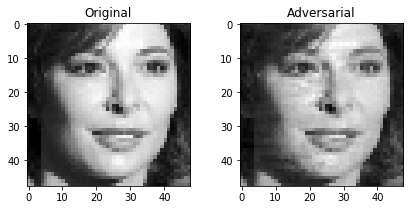

In [83]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title("Original")

Xmod = X + DX
Xmod_render = Xmod.numpy() * 256 + 128
plt.subplot(122)
plt.imshow(Xmod_render, cmap='gray')
plt.title("Adversarial")
plt.show()

The image still looks like a woman, but the rendering gives the impression of an image with a low quality. The neural network was looking for the lowest loss, in order to compute the filter that will mislead the most the prediction. It's not necessary to have such a lowest loss. In order to increase it, we will penalize the model with a L2 regularization. 

## Lower the noise with an L2 constraint

We add a L2 regularization when computing the loss. The regularization factor, beta, is set as 0.5 in order to have a strong regularization. It was chosen after several tests.

In [87]:
def train_filter_l2(model, optimizer, X, label, DX, beta):
    with tf.GradientTape() as tape:
        y = model(X + DX)
        y = tf.nn.log_softmax(y)
        diff = label * y
        loss = -tf.reduce_sum(diff) + beta*tf.nn.l2_loss(DX)
        grads = tape.gradient(loss, [DX])
        optimizer.apply_gradients(zip(grads, [DX]))
    return loss

for iter in range(1000):
    loss = train_filter_l2(simple_cnn, optimizer, X, fake_label, DX, 0.5)
    if iter % 100 == 0:
        print("iter= %6d - loss= %f" % (iter, loss))
print("iter= %6d - loss= %f" % (999, loss))

iter=      0 - loss= 0.120747
iter=    100 - loss= 0.120795
iter=    200 - loss= 0.120810
iter=    300 - loss= 0.120768
iter=    400 - loss= 0.120750
iter=    500 - loss= 0.120808
iter=    600 - loss= 0.120797
iter=    700 - loss= 0.120804
iter=    800 - loss= 0.120783
iter=    900 - loss= 0.120747
iter=    999 - loss= 0.120790


The obtained loss is really higher than previously (nearly 700 times higher), but it is still low enough in order to mislead the neural network during the prediction.

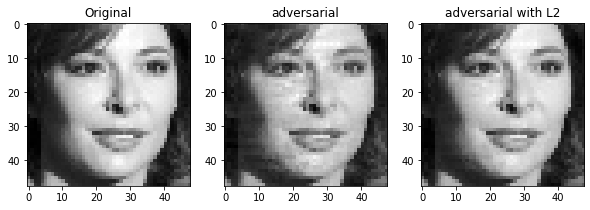

In [43]:
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(im, cmap='gray')
plt.title("Original")

plt.subplot(132)
plt.imshow(Xmod_render, cmap='gray')
plt.title("Adversarial")

XmodL2 = X + DX
XmodL2_render = XmodL2.numpy() * 256 + 128
plt.subplot(133)
plt.imshow(XmodL2_render, cmap='gray')
plt.title("Adversarial with L2")
plt.show()

The face looks less damaged and more natural.

## Verify that the model is misleaded

We will predict the gender of the transformed image, to see if it misleads the neural network.<br />
To do so, we compute for each image the probability of belonging to each class.

In [102]:
images = np.array([im, Xmod, XmodL2], dtype=np.float32)
y_pred = simple_cnn(images)
y_pred = y_pred.numpy()
result = tf.argmax(y_pred, 1).numpy()
result_labeled = np.where(result == 0, "Man", "Woman")
image_names = ["Original", "Adversarial", "Adversarial with L2"]

for i in range(0,3):
    print("Image {:s}: {:s} (scores: man: {:3f}, woman: {:3f})".format(image_names[i], result_labeled[i], y_pred[i,0], y_pred[i,1]))

Image Original: Woman (scores: man: -0.786289, woman: 1.691635)
Image Adversarial: Man (scores: man: 4.287148, woman: -4.397744)
Image Adversarial with L2: Man (scores: man: 1.876860, woman: -1.570869)


The transformed images have misleaded the model and be labeled as men. The image with the L2 constraint has a lowest score than without, but still correct.

# Conclusion

This lab shows that it is possible to mislead a neural network trained to do classification, by modifying the inputs with a filter.
An interesting part of the process is that the filter is computed by the same neural network, modified with a new variable added, representing the filter.
The result is that we can obtain an image nearly similar for the human eye, but different for the artificial intelligence system.

Then, we saw that it is important to choose a compromise between a very modified image, which strongly misleads the neural network, or a slightly modified image, more discreet for the human eye.